In [15]:
import numpy as np
from itertools import combinations
from scipy.optimize import milp, LinearConstraint, Bounds
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [4]:
# ---------- ★ 入力データ ----------------------------------------------------
w = np.array([3, 3, 2, 4, 2, 1, 1, 1], dtype=float)   # 幅  (長方形1…8)
h = np.array([4, 2, 2, 3, 1, 1, 1, 1], dtype=float)   # 高さ
W = 10.0                                              # 枠幅
eps = 0.0                                             # 3 と 4 の間隔 (0 なら接触可)
# ---------------------------------------------------------------------------

N = len(w)
pairs = [(i, j) for i, j in combinations(range(N), 2)]
P = len(pairs)                         # ペア数 = N*(N-1)/2
Mx = W                                 # Big‑M (横)
My = h.sum()                           # Big‑M (縦) ここでは高さ総和を上界に
H_ub = My

# --------------- 変数インデックス ------------------------------------------
idx_x   = np.arange(N)                                 # x_0 … x_{N-1}
idx_y   = np.arange(N)   + idx_x[-1] + 1               # y_0 … y_{N-1}
idx_H   = idx_y[-1] + 1                                # H_max
idx_L   = idx_H   + 1 + np.arange(P)                   # L_{ij}
idx_R   = idx_L[-1] + 1 + np.arange(P)                 # R_{ij}
idx_D   = idx_R[-1] + 1 + np.arange(P)                 # D_{ij}
idx_U   = idx_D[-1] + 1 + np.arange(P)                 # U_{ij}
n_var   = idx_U[-1] + 1                                # 総変数数
# ---------------------------------------------------------------------------

rows, cols, data, lower, upper = [], [], [], [], []    # 行列 A と境界を作るヘルパ

def add_row(coefs, rhs_low, rhs_up):
    """coefs は (var_idx, value) のリスト。行を1つ追加"""
    row_id = len(lower)
    for j, v in coefs:
        rows.append(row_id); cols.append(j); data.append(v)
    lower.append(rhs_low); upper.append(rhs_up)

# --------------- 1) 枠内 & 高さ定義 ----------------------------------------
for i in range(N):
    # x_i ≥ 0         →  0*x + 1*x_i ≥ 0        (下界のみ)
    add_row([(idx_x[i],  1.0)], 0.0,  np.inf)
    # x_i ≤ W - w_i   →              ≤ W-w_i    (上界のみ)
    add_row([(idx_x[i],  1.0)], -np.inf, W - w[i])
    # y_i ≥ 0
    add_row([(idx_y[i],  1.0)], 0.0,  np.inf)
    # y_i + h_i ≤ H_max
    add_row([(idx_y[i], 1.0), (idx_H, -1.0)], -np.inf, -h[i])

# --------------- 2) 非重なり Big‑M -----------------------------------------
for p, (i, j) in enumerate(pairs):
    L, R, D, U = idx_L[p], idx_R[p], idx_D[p], idx_U[p]

    # x_i + w_i ≤ x_j + Mx(1 - L_ij)
    add_row([(idx_x[i], 1.0), (idx_x[j], -1.0), (L, Mx)], -np.inf, -w[i] + Mx)
    # x_j + w_j ≤ x_i + Mx(1 - R_ij)
    add_row([(idx_x[j], 1.0), (idx_x[i], -1.0), (R, Mx)], -np.inf, -w[j] + Mx)
    # y_i + h_i ≤ y_j + My(1 - D_ij)
    add_row([(idx_y[i], 1.0), (idx_y[j], -1.0), (D, My)], -np.inf, -h[i] + My)
    # y_j + h_j ≤ y_i + My(1 - U_ij)
    add_row([(idx_y[j], 1.0), (idx_y[i], -1.0), (U, My)], -np.inf, -h[j] + My)
    # L+R+U+D ≥ 1   →  -L -R -U -D ≤ -1
    add_row([(L, -1.0), (R, -1.0), (U, -1.0), (D, -1.0)], -np.inf, -1.0)

# --------------- 3) 相対位置制約 3 が 4 の左 -------------------------------
# インデックスは 0-based なので 3→index 2, 4→index 3
add_row([(idx_x[2], 1.0), (idx_x[3], -1.0)], -np.inf, -w[2] - eps)

# --------------- 4) H_max 上界 (任意) --------------------------------------
add_row([(idx_H, 1.0)], -np.inf, H_ub)

# --------------- 行列 & 線形制約オブジェクト ------------------------------
A = csc_matrix((data, (rows, cols)), shape=(len(lower), n_var))
lincon = LinearConstraint(A, np.array(lower), np.array(upper))

# --------------- 目的関数 & 変数タイプ・範囲 -------------------------------
c = np.zeros(n_var)
c[idx_H] = 1.0                            # minimize H_max

integrality = np.zeros(n_var, dtype=int)  # 0 = continuous
integrality[np.r_[idx_L, idx_R, idx_D, idx_U]] = 1  # binary

lb = np.zeros(n_var)
ub = np.full(n_var, np.inf)
# バイナリの上限を 1 に
ub[np.r_[idx_L, idx_R, idx_D, idx_U]] = 1
bounds = Bounds(lb, ub)

# --------------- 求解 ------------------------------------------------------
res = milp(c, integrality=integrality, bounds=bounds,
           constraints=lincon,
           options={'disp': True})

print("status:", res.status, res.message)
if res.success:
    x = res.x
    print("最小高さ H_max =", x[idx_H])
    print("x 座標:", x[idx_x])
    print("y 座標:", x[idx_y])


Running HiGHS 1.2.2 [date: 2022-07-29, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
status: 0 Optimization terminated successfully. (HiGHS Status 7: Optimal)
最小高さ H_max = 4.0
x 座標: [0. 3. 4. 6. 7. 3. 6. 3.]
y 座標: [0. 2. 0. 0. 3. 0. 3. 1.]
Presolving model
149 rows, 129 cols, 466 nonzeros
148 rows, 128 cols, 462 nonzeros

Solving MIP model with:
   148 rows
   128 cols (111 binary, 0 integer, 0 implied int., 17 continuous)
   462 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   4               inf                  inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   4               8                 50.00%        0      0      0        52     0.0s
 L       0       0         0   0.00%   4     

In [11]:
# ---------- ★ 入力データ ----------------------------------------------------
w = np.array([3, 3, 2, 4, 2, 1, 1, 1], dtype=float)   # 幅  (長方形1…8)
h = np.array([4, 2, 2, 3, 1, 1, 1, 1], dtype=float)   # 高さ
W = 10.0
H = 8.0                                              # 枠幅
eps = 0.0                                             # 3 と 4 の間隔 (0 なら接触可)
# ---------------------------------------------------------------------------

N = len(w)
pairs = [(i, j) for i, j in combinations(range(N), 2)]
P = len(pairs)                         # ペア数 = N*(N-1)/2
Mx = W                                 # Big‑M (横)
My = H                                 # Big‑M (縦) ここでは高さ総和を上界に
H_ub = My

# --------------- 変数インデックス ------------------------------------------
idx_x   = np.arange(N)                                 # x_0 … x_{N-1}
idx_y   = np.arange(N)   + idx_x[-1] + 1               # y_0 … y_{N-1}
idx_H   = idx_y[-1] + 1                                # H_max
idx_L   = idx_H   + 1 + np.arange(P)                   # L_{ij}
idx_R   = idx_L[-1] + 1 + np.arange(P)                 # R_{ij}
idx_D   = idx_R[-1] + 1 + np.arange(P)                 # D_{ij}
idx_U   = idx_D[-1] + 1 + np.arange(P)                 # U_{ij}
n_var   = idx_U[-1] + 1                                # 総変数数
# ---------------------------------------------------------------------------

rows, cols, data, lower, upper = [], [], [], [], []    # 行列 A と境界を作るヘルパ

def add_row(coefs, rhs_low, rhs_up):
    """coefs は (var_idx, value) のリスト。行を1つ追加"""
    row_id = len(lower)
    for j, v in coefs:
        rows.append(row_id); cols.append(j); data.append(v)
    lower.append(rhs_low); upper.append(rhs_up)

# --------------- 1) 枠内 & 高さ定義 ----------------------------------------
for i in range(N):
    # x_i ≥ 0         →  0*x + 1*x_i ≥ 0        (下界のみ)
    add_row([(idx_x[i],  1.0)], 0.0,  np.inf)
    # x_i ≤ W - w_i   →              ≤ W-w_i    (上界のみ)
    add_row([(idx_x[i],  1.0)], -np.inf, W - w[i])
    # y_i ≥ 0
    add_row([(idx_y[i],  1.0)], 0.0,  np.inf)
    # y_i + h_i ≤ H_max
    add_row([(idx_y[i], 1.0), (idx_H, -1.0)], -np.inf, -h[i])

# --------------- 2) 非重なり Big‑M -----------------------------------------
for p, (i, j) in enumerate(pairs):
    L, R, D, U = idx_L[p], idx_R[p], idx_D[p], idx_U[p]

    # x_i + w_i ≤ x_j + Mx(1 - L_ij)
    add_row([(idx_x[i], 1.0), (idx_x[j], -1.0), (L, Mx)], -np.inf, -w[i] + Mx)
    # x_j + w_j ≤ x_i + Mx(1 - R_ij)
    add_row([(idx_x[j], 1.0), (idx_x[i], -1.0), (R, Mx)], -np.inf, -w[j] + Mx)
    # y_i + h_i ≤ y_j + My(1 - D_ij)
    add_row([(idx_y[i], 1.0), (idx_y[j], -1.0), (D, My)], -np.inf, -h[i] + My)
    # y_j + h_j ≤ y_i + My(1 - U_ij)
    add_row([(idx_y[j], 1.0), (idx_y[i], -1.0), (U, My)], -np.inf, -h[j] + My)
    # L+R+U+D ≥ 1   →  -L -R -U -D ≤ -1
    add_row([(L, -1.0), (R, -1.0), (U, -1.0), (D, -1.0)], -np.inf, -1.0)

# --------------- 3) 相対位置制約 3 が 4 の左 -------------------------------
# インデックスは 0-based なので 3→index 2, 4→index 3
add_row([(idx_x[2], 1.0), (idx_x[3], -1.0)], -np.inf, -w[2] - eps)

# --------------- 4) H_max 上界 (任意) --------------------------------------
add_row([(idx_H, 1.0)], -np.inf, H_ub)

# --------------- 行列 & 線形制約オブジェクト ------------------------------
A = csc_matrix((data, (rows, cols)), shape=(len(lower), n_var))
lincon = LinearConstraint(A, np.array(lower), np.array(upper))

# --------------- 目的関数 & 変数タイプ・範囲 -------------------------------
c = np.zeros(n_var)
# c[idx_H] = 1.0                            # minimize H_max

integrality = np.zeros(n_var, dtype=int)  # 0 = continuous
integrality[np.r_[idx_L, idx_R, idx_D, idx_U]] = 1  # binary

lb = np.zeros(n_var)
ub = np.full(n_var, np.inf)
# バイナリの上限を 1 に
ub[np.r_[idx_L, idx_R, idx_D, idx_U]] = 1
bounds = Bounds(lb, ub)

# --------------- 求解 ------------------------------------------------------
res = milp(c, integrality=integrality, bounds=bounds,
           constraints=lincon,
           options={'disp': True})

print("status:", res.status, res.message)
if res.success:
    x = res.x
    print("最小高さ H_max =", x[idx_H])
    print("x 座標:", x[idx_x])
    print("y 座標:", x[idx_y])


status: 0 Optimization terminated successfully. (HiGHS Status 7: Optimal)
最小高さ H_max = 8.0
x 座標: [1. 1. 4. 6. 8. 0. 4. 0.]
y 座標: [3. 0. 5. 0. 3. 7. 7. 4.]
Running HiGHS 1.2.2 [date: 2022-07-29, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
141 rows, 128 cols, 450 nonzeros
140 rows, 127 cols, 446 nonzeros
Objective function is integral with scale 1

Solving MIP model with:
   140 rows
   127 cols (111 binary, 0 integer, 0 implied int., 16 continuous)
   446 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   0               inf                  inf        0      0      3        54     0.0s



In [13]:
import numpy as np
from itertools import combinations
from scipy.optimize import milp, LinearConstraint, Bounds
from scipy.sparse import csc_matrix

# ---------- (1) まず元のモデルを関数にまとめておく -------------
def build_model(w, h, W, H, eps=0.0, extra_rows=None):
    """
    extra_rows : list[ (coef_list, low, up) ]
                 追加の制約行 (no-good cut など) を渡す
    戻り値: (c, integrality, bounds, lincon, idx_pack)
    """
    N = len(w); pairs = list(combinations(range(N), 2)); P = len(pairs)
    Mx, My = W, H; H_ub = H

    # --- 変数インデックス -------------------------------------------------
    idx_x = np.arange(N)
    idx_y = np.arange(N) + idx_x[-1] + 1
    idx_H = idx_y[-1] + 1
    idx_L = idx_H + 1 + np.arange(P)
    idx_R = idx_L[-1] + 1 + np.arange(P)
    idx_D = idx_R[-1] + 1 + np.arange(P)
    idx_U = idx_D[-1] + 1 + np.arange(P)
    n_var = idx_U[-1] + 1

    # --- 行列Aを組む ------------------------------------------------------
    rows, cols, data, lower, upper = [], [], [], [], []
    def add_row(coefs, rhs_low, rhs_up):
        rid = len(lower)
        for j, v in coefs:
            rows.append(rid); cols.append(j); data.append(v)
        lower.append(rhs_low); upper.append(rhs_up)

    # 1) 枠内 & 最大高さ定義
    for i in range(N):
        add_row([(idx_x[i], 1)],          0, np.inf)
        add_row([(idx_x[i], 1)], -np.inf, W - w[i])
        add_row([(idx_y[i], 1)],          0, np.inf)
        add_row([(idx_y[i], 1), (idx_H, -1)], -np.inf, -h[i])

    # 2) 非重なり Big‑M
    for p, (i, j) in enumerate(pairs):
        L, R, D, U = idx_L[p], idx_R[p], idx_D[p], idx_U[p]
        add_row([(idx_x[i], 1), (idx_x[j], -1), (L, Mx)], -np.inf, -w[i] + Mx)
        add_row([(idx_x[j], 1), (idx_x[i], -1), (R, Mx)], -np.inf, -w[j] + Mx)
        add_row([(idx_y[i], 1), (idx_y[j], -1), (D, My)], -np.inf, -h[i] + My)
        add_row([(idx_y[j], 1), (idx_y[i], -1), (U, My)], -np.inf, -h[j] + My)
        add_row([(L, 1), (R, 1), (D, 1), (U, 1)], 1, np.inf)  # ≥1

    # 3) 相対位置: 3 は 4 の左
    add_row([(idx_x[2], 1), (idx_x[3], -1)], -np.inf, -w[2] - eps)

    # 4) H_max 上界
    add_row([(idx_H, 1)], -np.inf, H_ub)

    # 5) extra_rows があれば追加
    if extra_rows:
        for coef_list, lo, up in extra_rows:
            add_row(coef_list, lo, up)

    A = csc_matrix((data, (rows, cols)), shape=(len(lower), n_var))
    lincon = LinearConstraint(A, np.array(lower), np.array(upper))

    # --- 目的 = 0 (可行解のみ) -----------------------------
    c = np.zeros(n_var)

    # --- integrality & bounds -----------------------------
    integrality = np.zeros(n_var, dtype=int)
    integrality[np.r_[idx_L, idx_R, idx_D, idx_U]] = 1

    lb = np.zeros(n_var)
    ub = np.full(n_var, np.inf)
    ub[np.r_[idx_L, idx_R, idx_D, idx_U]] = 1
    bounds = Bounds(lb, ub)

    idx_pack = dict(idx_x=idx_x, idx_y=idx_y,
                    idx_L=idx_L, idx_R=idx_R, idx_D=idx_D, idx_U=idx_U)

    return c, integrality, bounds, lincon, idx_pack
# -------------------------------------------------------------------------

# ---------- (2) 例としてデータを用意 -----------------------------
w = np.array([3,3,2,4,2,1,1,1])
h = np.array([4,2,2,3,1,1,1,1])
W = 10.0
H = 8.0                     
K = 5                     # ← 欲しい解の個数
eps = 0.0
solutions = []            # (x_vec, objective) を溜める
extra_rows = []           # 追加 no-good cut 用の行

for k in range(K):
    c, integ, bounds, lincon, idx_pack = build_model(
        w, h, W, H, eps, extra_rows)

    res = milp(c, integrality=integ, bounds=bounds,
               constraints=lincon,
               options={'disp': False, 'node_limit': 1})  # 最短探索

    if res.status != 0:          # 0 = optimal(=可行)　以外なら終了
        print(f"{k} 個で打ち止め: {res.message}")
        break

    xvec = res.x
    solutions.append(xvec)
    print(f"### Solution {k+1}")
    # print(" H_max :", xvec[idx_pack['idx_H']])
    print(" x:", xvec[idx_pack['idx_x']])
    print(" y:", xvec[idx_pack['idx_y']])

    # --------- (3)  no‑good cut 追加 --------------------
    bin_indices = np.r_[idx_pack['idx_L'],
                        idx_pack['idx_R'],
                        idx_pack['idx_D'],
                        idx_pack['idx_U']]
    ones_idx  = [j for j in bin_indices if xvec[j] > 0.5]
    k_ones    = len(ones_idx)
    if k_ones == 0:
        print("全バイナリが0 → 他解を区別できないので打ち止め")
        break
    # Σ_{i∈ones} b_i ≤ k_ones - 1
    cut = ([(j, 1.0) for j in ones_idx], -np.inf, k_ones - 1)
    extra_rows.append(cut)
# -------------------------------------------------------------------------


### Solution 1
 x: [1. 1. 4. 6. 8. 0. 4. 0.]
 y: [3. 0. 5. 0. 3. 7. 7. 4.]
### Solution 2
 x: [7. 7. 0. 3. 7. 2. 0. 1.]
 y: [1. 5. 5. 2. 0. 7. 1. 7.]
### Solution 3
 x: [1. 7. 0. 6. 8. 5. 0. 6.]
 y: [0. 3. 5. 0. 5. 7. 7. 6.]
### Solution 4
 x: [6. 6. 0. 2. 1. 0. 9. 0.]
 y: [0. 4. 0. 0. 3. 7. 4. 6.]
### Solution 5
 x: [1. 7. 4. 6. 1. 0. 0. 0.]
 y: [0. 2. 6. 4. 7. 0. 2. 1.]


/var/folders/xy/r5kzx9ms6vx1ssrpr592_w7r0000gn/T/ipykernel_32440/3579398840.py:96: RuntimeWarning: Unrecognized options detected: {'node_limit'}. These will be passed to HiGHS verbatim.
  res = milp(c, integrality=integ, bounds=bounds,


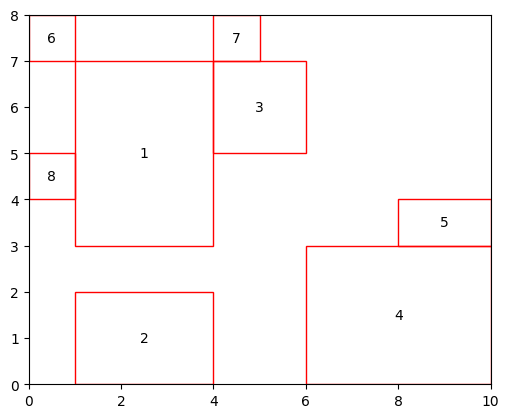

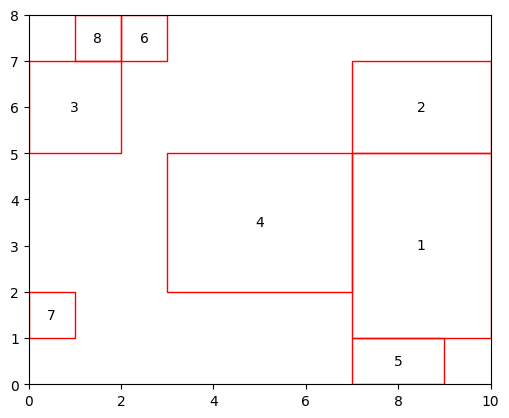

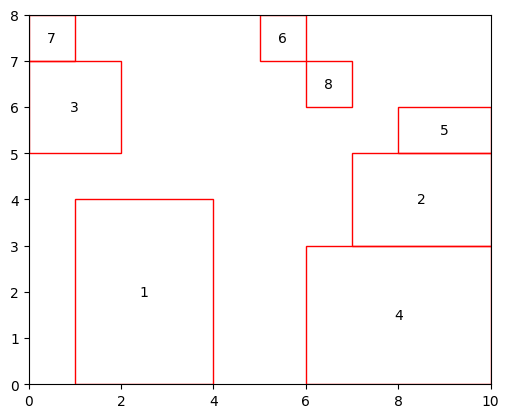

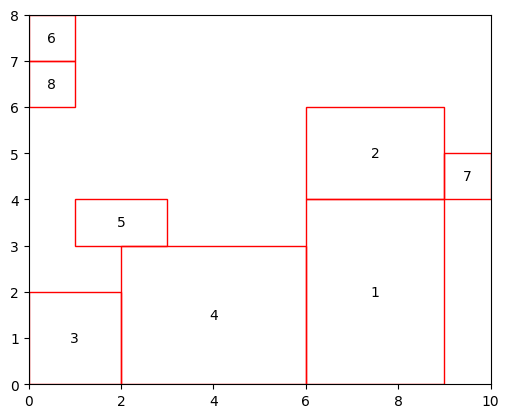

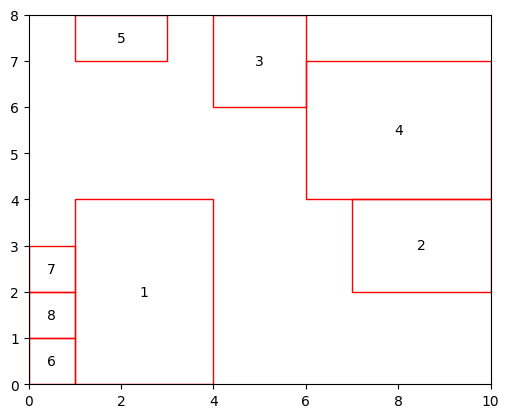

In [20]:
# 各長方形の幅と高さ
w = np.array([3,3,2,4,2,1,1,1])
h = np.array([4,2,2,3,1,1,1,1])
# 箱の横幅がWで縦幅がHの場合
W = 10.0
H = 8.0

# ### Solution 1
x=[1, 1, 4, 6, 8, 0, 4, 0,]
y=[3, 0, 5, 0, 3, 7, 7, 4,]
# 描画する（長方形の番号も表示）
fig, ax = plt.subplots()
for i in range(len(w)):
    rect = patches.Rectangle((x[i], y[i]), w[i], h[i], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x[i] + w[i]/2, y[i] + h[i]/2, str(i+1), ha='center', va='center')
ax.set_xlim(0, W)
ax.set_ylim(0, H)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("solution1.png")
plt.show()


### Solution 2
x=[7, 7, 0, 3, 7, 2, 0, 1,]
y=[1, 5, 5, 2, 0, 7, 1, 7,]
fig, ax = plt.subplots()
for i in range(len(w)):
    rect = patches.Rectangle((x[i], y[i]), w[i], h[i], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x[i] + w[i]/2, y[i] + h[i]/2, str(i+1), ha='center', va='center')
ax.set_xlim(0, W)
ax.set_ylim(0, H)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("solution2.png")
plt.show()


### Solution 3
x=[1, 7, 0, 6, 8, 5, 0, 6,]
y=[0, 3, 5, 0, 5, 7, 7, 6,]
fig, ax = plt.subplots()
for i in range(len(w)):
    rect = patches.Rectangle((x[i], y[i]), w[i], h[i], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x[i] + w[i]/2, y[i] + h[i]/2, str(i+1), ha='center', va='center')
ax.set_xlim(0, W)
ax.set_ylim(0, H)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("solution3.png")
plt.show()


### Solution 4
x=[6, 6, 0, 2, 1, 0, 9, 0,]
y=[0, 4, 0, 0, 3, 7, 4, 6,]
fig, ax = plt.subplots()
for i in range(len(w)):
    rect = patches.Rectangle((x[i], y[i]), w[i], h[i], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x[i] + w[i]/2, y[i] + h[i]/2, str(i+1), ha='center', va='center')
ax.set_xlim(0, W)
ax.set_ylim(0, H)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("solution4.png")
plt.show()


### Solution 5
x=[1, 7, 4, 6, 1, 0, 0, 0,]
y=[0, 2, 6, 4, 7, 0, 2, 1,]
fig, ax = plt.subplots()
for i in range(len(w)):
    rect = patches.Rectangle((x[i], y[i]), w[i], h[i], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x[i] + w[i]/2, y[i] + h[i]/2, str(i+1), ha='center', va='center')
ax.set_xlim(0, W)
ax.set_ylim(0, H)
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("solution5.png")
plt.show()